# Testing Notebook 03

This notebook is where I'm developing the containment methods for multivariate functions in $\mathbb{R}^n$

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from statdepth.depth._containment import _is_in_simplex
from statdepth.depth._depthcalculations import _subsequences

First, create some multidimensional data

In [105]:
data = []

df1 = pd.DataFrame(np.random.randint(0,5,size=(30, 3)), columns=list('ABC'))
df2 = pd.DataFrame(np.random.randint(0,5,size=(30, 3)), columns=list('ABC'))
df3 = pd.DataFrame(np.random.randint(0,5,size=(30, 3)), columns=list('ABC'))
df4 = pd.DataFrame(np.random.randint(0,5,size=(30, 3)), columns=list('ABC'))
df5 = pd.DataFrame(np.random.randint(0,5,size=(30, 3)), columns=list('ABC'))
df6 = pd.DataFrame(np.random.randint(0,5,size=(30, 3)), columns=list('ABC'))

data = [df1, df2, df3, df4, df5, df6]

In [106]:
from scipy.special import binom
from statdepth.depth._containment import _is_in_simplex
from statdepth.depth._depthcalculations import _subsequences
from typing import List

def _simplex_containment(data: List[pd.DataFrame], curve: pd.DataFrame, J=2, relax=False):
    n = len(data)
    l, d = data[0].shape
    
    # Iterate over our subsequences of functions to form simplex with d+1 vertices
    containment = 0

    # For each time index, check containment 
    for idx in curve.index:
        containment += _is_in_simplex(simplex_points=np.array([df.loc[idx, :] for df in data]), 
                                point=np.array(curve.loc[idx, :]))
    
    # If relaxation, return proportion of containment, else return integer divion so that we 
    # only get 1 if all rows are contained
    return containment / l if relax else containment // l
    

In [107]:
def _simplex_depth(data: list, curve: pd.DataFrame, J=2, relax=False):
    l, d = data[0].shape
    n = len(data)
    depth = 0
    
    for j in range(2, J + 1):
        S_nj = 0
        subseq = _subsequences([i for i in range(n)], d + 1)
        
        for seq in subseq:
            cdata = [data[i] for i in seq]
            S_nj += _simplex_containment(data=data, curve=curve, relax=relax)
        
        depth += S_nj / binom(n, d + 1)

    return depth

def banddepthtest(data: list, J=2, relax=False):
    depths = []
    f = [i for i in range(len(data))]
    for cdf in data:
        cdata = [df for df in data if df is not cdf]
        depths.append(_simplex_depth(data=cdata, curve=cdf, J=J, relax=relax))
        
    return pd.Series(index=f, data=depths)

In [108]:
banddepthtest(data=data, J=2, relax=True)

S_nj before division: 0.16666666666666666
binom is 5.0
S_nj before division: 0.16666666666666666
binom is 5.0
S_nj before division: 0.5
binom is 5.0
S_nj before division: 0.16666666666666666
binom is 5.0
S_nj before division: 0.8333333333333333
binom is 5.0
S_nj before division: 0.3333333333333333
binom is 5.0


0    0.033333
1    0.033333
2    0.100000
3    0.033333
4    0.166667
5    0.066667
dtype: float64

In [93]:
from typing import List
from statdepth.depth.depth import _univariate_band_depth
from statdepth.depth._containment import _r2_containment

def _r2_enum_containment(data: List[pd.DataFrame], curve: pd.DataFrame, relax: bool) -> float:
    depths = pd.DataFrame()
    
    for i in range(0, len(data)):
        curve = data[i]
        c_depths = []
        
        for col in curve.columns:
            t = pd.DataFrame(index=data[0].index)

            for df, index in zip(data, [k for k in range(len(data))]):
                t[col + str(index)] = df[col]

            t['curve'] = curve[col]
            c_depths.append(_univariate_band_depth(data=t, curve='curve', relax=True, containment=_r2_containment))

        depths[i] = pd.Series(index=curve.columns, data=c_depths)
    return depths

In [97]:
%%timeit
s = _r2_enum_containment(data=data, curve=data[0], relax=False)

73.4 ms ± 833 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
depths = pd.DataFrame()

for i in range(0, len(data)):
    depths[i] = _r2_enum_containment(data=data, curve=data[i], relax=False)

depths

,0,1,2,3
A,0.456667,0.45,0.423333,0.460000
B,0.493333,0.45,0.463333,0.446667
C,0.510000,0.44,0.436667,0.493333


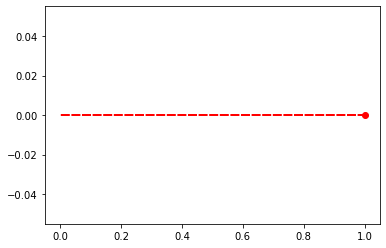

In [194]:
from scipy.spatial import ConvexHull, Delaunay
import matplotlib.pyplot as plt

points = np.array([[0,0], [1,0], [1,0]])
hull = ConvexHull(points, qhull_options='QJ', incremental=True)

def plot_hull(hull, points):

    plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)

    plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')

    plt.show()
    
plot_hull(hull, points)

In [195]:
hull.vertices

array([1, 0, 2], dtype=int32)

In [209]:
p = [list(x) for x in points]

p.append([0,0])
np.array(p)

array([[0, 0],
       [1, 0],
       [1, 0],
       [0, 0]])

In [213]:
tp = [4,5]

if tp not in points:
    p = [list(x) for x in points]
    p.append(tp)
    hull = ConvexHull(np.array(p), qhull_options='QJ')
else:
    hull = ConvexHull(points, qhull_options='QJ')

hull.vertices

[[0, 0], [1, 0], [1, 0], [4, 5]]


array([3, 0, 2], dtype=int32)

In [152]:
plot_hull(hull)

IndexError: index 3 is out of bounds for axis 0 with size 3

In [282]:
points = np.array([[0,0,0], [1,0,0], [0,0,1], [0,0,0]])

def isinsimplex(simplex_points, point):
    
    # If the point is a vertex, no work to be done (on a face is considered contained)
    if point in simplex_points:
        return True

    # Generate convex hull and grab its vertices. If this errors, the hull is degenerate and we consider the point not contained
    hull = ConvexHull(simplex_points, incremental=True, qhull_options='QJ') # 'QJ' option allows geometric degeneracy

    vertices = hull.vertices
    
    # Generate the convex hull with new point
    hull.add_points([point])
    
    # Check if they are the same
    # If they are, then the added point must be contained in the original hull
    # If there are a different number of vertices, clearly the hulls are different
    if len(vertices) != len(hull.vertices):
        return False
    
    # Otherwise, make sure all the vertices are the same
    return all(vertices == hull.vertices)

from scipy.optimize import linprog

def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    
    c = np.zeros(n_points)
    A = np.r_[points.T, np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    
    lp = linprog(c, A_eq=A, b_eq=b)
    
    return lp.success

in_hull(points, [.5,0,0]), isinsimplex(points, [, .5, .5])

(True, True)

In [285]:
def isinsimplex(simplex_points, point) -> bool:
    n_points = len(simplex_points)
    n_dim = len(point)
    
    c = np.zeros(n_points)
    A = np.r_[simplex_points.T, np.ones((1,n_points))]
    b = np.r_[point, np.ones(1)]
    
    lp = linprog(c, A_eq=A, b_eq=b)
    
    return lp.success

isinsimplex(points, [.5, 0, 0])

True

In [ ]:
def simplex_containment(data, curve, J=2):
    depth = 0 # Initialize depth (number of simplices containing the data) to zero
    n = len(data) # Number of functions
    d = data[0].shape[1] # Number of features (features live in p dimensional space)
    
    subseq = _subsequences([i for i in range(n)], d + 1) # Create d+1 dimensional subsequences to form simplices from the n samples
    
    for sequence in subeq:
        pass
    